In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [53]:
from pathlib import Path

from tqdm import tqdm
import cv2
import numpy as np
from keras import utils
import matplotlib.pyplot as plt

from converter import Mc2RealConverter

In [4]:
mc2real = Mc2RealConverter()

2023-06-29 23:22:33.644397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 23:22:33.662754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-29 23:22:33.662919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Quick test

In [5]:
dataset = utils.image_dataset_from_directory(
    directory='sample_images',
    image_size=(256, 256),
    labels=None,
    batch_size=1,
)

Found 10405 files belonging to 1 classes.


2023-06-29 23:22:55.753436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10405]
	 [[{{node Placeholder/_0}}]]
2023-06-29 23:22:55.753662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10405]
	 [[{{node Placeholder/_0}}]]


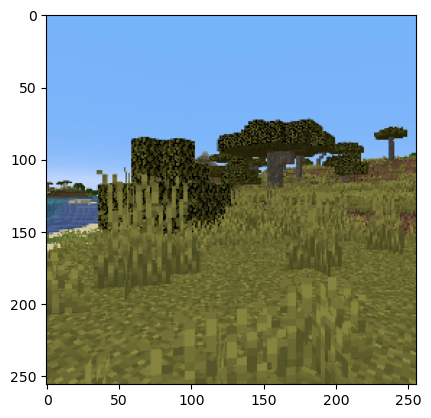

In [6]:
mc_image = next(iter(dataset))[0].numpy() / 255
plt.imshow(mc_image)

2023-06-29 23:23:02.324195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-06-29 23:23:03.821392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-29 23:23:03.840670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1,256,256,25]
	 [[{{node Placeholder/_1}}]]


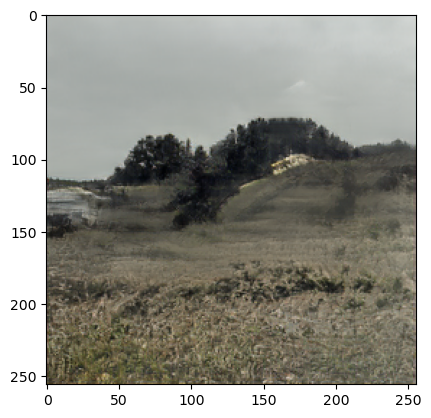

In [7]:
real_image = mc2real(mc_image)
plt.imshow(real_image)

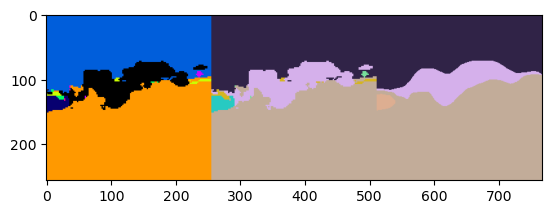

In [8]:
m1, m2, m3 = mc2real.get_last_masks()
masks = np.concatenate([m1, m2, m3], axis=1)
plt.imshow(masks)

## Convert whole dataset

In [48]:
input_dataset = utils.image_dataset_from_directory(
    directory='dataset/minecraft',
    image_size=(256, 256),
    labels=None,
    batch_size=None,
)

Found 10405 files belonging to 1 classes.


In [70]:
def convert_single_image(root_path, idx, mc_image):
    mc_image = mc_image.numpy().astype(np.float32) / 255
    
    real_image = mc2real(mc_image).astype(np.float32) / 255
    joined_image = np.concatenate([mc_image, real_image], axis=1)
    
    mc_path = root_path / 'minecraft' / f'{idx:05}.png'
    real_path = root_path / 'real' / f'{idx:05}.png'
    joined_path = root_path / 'joined' / f'{idx:05}.png'
    
    cv2.imwrite(str(mc_path), mc_image[..., ::-1]*255)
    cv2.imwrite(str(real_path), real_image[..., ::-1]*255)
    cv2.imwrite(str(joined_path), joined_image[..., ::-1]*255)

In [72]:
def convert_dataset(root_path):
    for idx, mc_image in tqdm(enumerate(input_dataset), total=len(input_dataset)):
        convert_single_image(root_path, idx, mc_image)

In [ ]:
convert_dataset(Path('dataset_mc_real'))